<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/feature_engineering/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive

import numpy as np

import pandas as pd

import os

## PEP8 standard

In [2]:
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

## Importing custom packages

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}


git_download_path = \
    'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model


def reload_modules(modules):
    for module in modules:
        importlib.reload(module)


reload_modules(
    [
        path_manager,
        sklearn_transformers,
        sklearn_utils,
        model
    ]
)

from path_manager import PathManager
from sklearn_transformers import ColumnDropper
from sklearn_utils import inf_statistics
from model import Model

# Set up paths

In [5]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 2
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/preproc_trial_2 already exists
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Models/trial_1 already exists


# Fixing seed

In [6]:
RANDOM_SEED = 42
RANDOM_STATE = RANDOM_SEED

np.random.seed(42)

# Download the data

In [7]:
os.listdir(manager.data_trial_path)

['test_sample_processed.csv', 'test_processed.csv', 'trainval_processed.csv']

In [8]:
df_trainval = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'trainval_processed.csv'
    )
)
df_trainval.shape

X_trainval = df_trainval.values[:, :-1]
Y_trainval = df_trainval.values[:, -1]

In [9]:
df_test_sample = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_sample_processed.csv'
    )
)
df_test_sample.shape

X_test_sample = df_test_sample.values[:, :-1]
Y_test_sample = df_test_sample.values[:, -1]

# Define models

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
LogReg = Model(
    LogisticRegression(),
    'LogReg',
    [
        {
            'penalty': ['elasticnet'],
            'C': [0.01, 0.05, 0.1],
            'random_state': [RANDOM_STATE],
            'solver': ['saga'],
            'l1_ratio': [0, 0.01, 0.05]
        }
    ],
    [

    ]
)

In [12]:
from sklearn.ensemble import RandomForestClassifier


RandomForest = Model(
    RandomForestClassifier(),
    'RandomForest',
    [
        {
            'n_estimators': [75, 100],
            'max_depth': [4, 6],
            'bootstrap': [True, False],
            'max_features': ['sqrt', 'log2'],
            'random_state': [42],
            'n_jobs': [-1]
        }
    ],
    [

    ]
)

In [13]:
from sklearn.svm import SVC


SVM = Model(
    SVC(),
    'SVM',
    [
        {
            'C': [0.05, 0.1, 0.5, 1.0],
            'kernel': ['linear', 'rbf', 'poly'],
            'random_state': [RANDOM_STATE]
        }
    ],
    [
        
    ]
)

In [14]:
all_models = {
    model.name: model
    for model in [
        LogReg,
        RandomForest,
        SVM
    ]
}

# Shortlist models based on cross-validation behavior

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model           Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
------------  ----------------------  ----------------  ------------------------  ------------------
SVM                         0.778796        0.00176711                  0.772216          0.0108724
LogReg                      0.79048         0.00164665                  0.791775          0.00524118
RandomForest                1               0                           0.794652          0.0083247


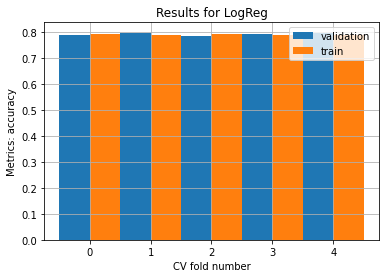

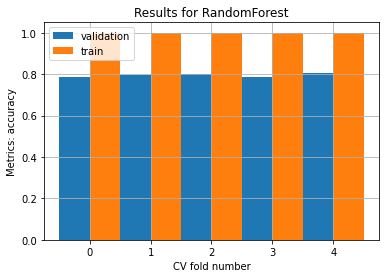

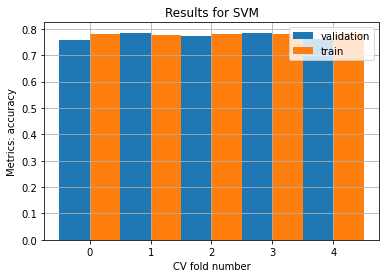

In [15]:
from sklearn_utils import plot_cv_results


np.random.seed(RANDOM_SEED)

res = plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model
        for model_name, model in all_models.items()
    },
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',  # 'accuracy'
    to_put_minus_=False
)

In [16]:
shortlisted_models = {
    model.name: model
    for model in [
        LogReg,
        SVM,
        RandomForest
    ]
}

# Fine tune shortlisted models with grid search

In [17]:
from sklearn_utils import fit_grid_search
from sklearn_utils import dict_subset

## Random forest

In [18]:
rf_results = fit_grid_search(
    models_dict_=dict_subset(
        shortlisted_models,
        ['RandomForest']
    ),
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=2
)

Fitting RandomForest
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   1.6s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=42; total time=   0.6s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=100, n_jobs=-1, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators

In [19]:
rf_results['RandomForest'].best_score_, \
    rf_results['RandomForest'].best_params_

(0.7812776895665352,
 RandomForestClassifier(max_depth=6, max_features='sqrt', n_jobs=-1,
                        random_state=42),
 100)

Model      Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------  ----------------------  ----------------  ------------------------  ------------------
RF                     0.795226        0.00200216                  0.781278          0.00564019


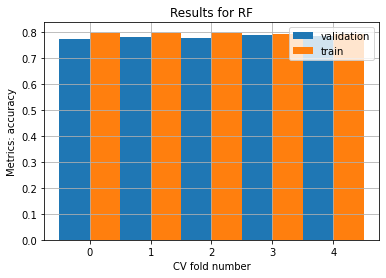

In [20]:
from sklearn_utils import plot_cv_results


_ = plot_cv_results(
    {'RF': rf_results['RandomForest'].best_estimator_},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy'
)

## SVM

In [ ]:
# from sklearn_utils import fit_grid_search


# svm_results = fit_grid_search(
#     dict_subset(
#         shortlisted_models,
#         ['SVM']
#     ),
#     X_=X_trainval,
#     Y_=Y_trainval,
#     cv_=5,
#     scoring_='accuracy',
#     verbose=5
# )

Fitting SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
# svm_results.best_score_

## LogReg

In [21]:
from sklearn_utils import fit_grid_search


log_reg_results = fit_grid_search(
    dict_subset(
        shortlisted_models,
        ['LogReg']
    ),
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=1
)

Fitting LogReg
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

In [22]:
log_reg_results['LogReg'].best_score_, \
    log_reg_results['LogReg'].best_params_

(0.7634428934207056,
 {'C': 0.01,
  'l1_ratio': 0,
  'penalty': 'elasticnet',
  'random_state': 42,
  'solver': 'saga'})

# Saving models

In [23]:
res_models = {
    # **log_reg_results,
    **rf_results
}
res_models

{'RandomForest': GridSearchCV(cv=5, estimator=RandomForestClassifier(),
              param_grid=[{'bootstrap': [True, False], 'max_depth': [4, 6],
                           'max_features': ['sqrt', 'log2'],
                           'n_estimators': [75, 100], 'n_jobs': [-1],
                           'random_state': [42]}],
              return_train_score=True, scoring='accuracy', verbose=2)}

In [24]:
manager.save_models(
    {
        f'{model_name}_gridsearch': result.best_estimator_
        for model_name, result in res_models.items()
    }
)

/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Models/trial_1/RandomForest_gridsearch already exists
